In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

from tqdm import tqdm

plt.style.use("dark_background")


## The Finite Volume Method in CFD video series

https://youtube.com/playlist?list=PLnJ8lIgfDbkp5DtCPtP2rcqEEUJk-PM8N&si=NvpF64pgI-nEt85i

### Classes

#### Node, Face, Cell classes


In [23]:
class Node:
    def __init__(self, id, coordinates):
        """
        Initialize a node.
        :param id: Global ID for the node.
        :param coordinates: Tuple of coordinates (x, y, z).
        """
        self.id = id
        self.coordinates = coordinates

    #     # TODO: do I even need this?
    #     self.neighbors = []  # List of neighboring node IDs


    # def add_neighbor(self, neighbor_id):
    #     self.neighbors.append(neighbor_id)

    def __repr__(self):
        return f"Node(id={self.id}, coordinates={self.coordinates}" #, neighbors={self.neighbors})"

class Face:
    def __init__(self, id, nodes):
        """
        Initialize a face.
        :param id: Global ID for the face.
        :param nodes: List of node IDs defining the face.
        """
        self.id = id
        self.nodes = nodes  # Nodes that make up the face

    #     # TODO: do I even need this?
    #     self.neighbor_cells = []  # IDs of adjacent cells

    # def add_neighbor_cell(self, cell_id):
    #     self.neighbor_cells.append(cell_id)

    def __repr__(self):
        return f"Face(id={self.id}, nodes={self.nodes}" #, neighbor_cells={self.neighbor_cells})"

class Cell:
    def __init__(self, id, nodes, faces):
        """
        Initialize a cell.
        :param id: Global ID for the cell.
        :param nodes: List of node IDs defining the cell.
        :param faces: List of face IDs defining the cell.
        """
        self.id = id
        self.nodes = nodes  # Nodes that make up the cell
        self.faces = faces  # Faces that bound the cell
        self.neighbor_cells = []  # IDs of adjacent cells

        self.flow_variables = {"T":None, "U":None, "P":None}

    def add_flow_variable(self, variable, value):
        self.flow_variables[variable] = value

    def get_flow_variable(self, variable):
        return self.flow_variables[variable]

    def add_neighbor_cell(self, neighbor_id):
        self.neighbor_cells.append(neighbor_id)

    def __repr__(self):
        return (f"Cell(id={self.id}, nodes={self.nodes}, faces={self.faces}, "
                f"neighbor_cells={self.neighbor_cells}, flow_variables={self.flow_variables})")


# Example usage
node1 = Node(1, (0.0, 0.0, 0.0))
node2 = Node(2, (1.0, 0.0, 0.0))
node3 = Node(3, (1.0, 1.0, 0.0))

face1 = Face(1, [1, 2])
face2 = Face(2, [2, 3])

cell1 = Cell(1, [1, 2, 3], [1, 2])

cell1.add_neighbor_cell(2)  # Cell 2 is a neighbor
# face1.add_neighbor_cell(1)  # Cell 1 is adjacent to face 1
# node1.add_neighbor(2)       # Node 2 is a neighbor of Node 1

#### Mesh class

In [24]:
class Mesh:
    def __init__(self, nodes, faces, cells):
        """
        Initialize an empty Mesh object with lists to store nodes, faces, and cells.
        """
        self.nodes = nodes
        self.faces = faces
        self.cells = cells

    def add_node(self, node):
        """
        Add a Node to the mesh.
        :param node: Node object to add.
        """
        self.nodes.append(node)

    def add_face(self, face):
        """
        Add a Face to the mesh.
        :param face: Face object to add.
        """
        self.faces.append(face)

    def add_cell(self, cell):
        """
        Add a Cell to the mesh.
        :param cell: Cell object to add.
        """
        self.cells.append(cell)

    def get_node(self, node_id):
        """
        Retrieve a Node by its ID.
        :param node_id: ID of the Node to retrieve.
        :return: Node object.
        """
        return next(node for node in self.nodes if node.id == node_id)

    def get_face(self, face_id):
        """
        Retrieve a Face by its ID.
        :param face_id: ID of the Face to retrieve.
        :return: Face object.
        """
        return next(face for face in self.faces if face.id == face_id)

    def get_cell(self, cell_id):
        """
        Retrieve a Cell by its ID.
        :param cell_id: ID of the Cell to retrieve.
        :return: Cell object.
        """
        return next(cell for cell in self.cells if cell.id == cell_id)

    def compute_cell_connectivity(self):
        """
        Compute and assign neighbors for each cell based on shared faces.
        """
        face_to_cells = {}

        # Map faces to the cells they belong to
        for cell in self.cells:
            for face_id in cell.faces:
                if face_id not in face_to_cells:
                    face_to_cells[face_id] = []
                face_to_cells[face_id].append(cell.id)

        # Assign neighbors using shared faces
        for face_id, cell_ids in face_to_cells.items():
            if len(cell_ids) > 1:  # A face shared by more than one cell
                for i, cell_id in enumerate(cell_ids):
                    for neighbor_id in cell_ids[:i] + cell_ids[i + 1:]:
                        self.get_cell(cell_id).add_neighbor_cell(neighbor_id)

    def print_detailed_info(self, config = "NFC"):
        """
        Print detailed information about the mesh, including nodes, faces, and cells.
        """
        if "N" in config:
            print("Nodes:")
            for node in self.nodes:
                print(node)
        if "F" in config:
            print("Faces:")
            for face in self.faces:
                print(face)
        if "C" in config:
            print("Cells:")
            for cell in self.cells:
                print(cell)

    def plot(self):
        """
        Plot the mesh using the plot_system function.
        """
        plot_system(self.nodes, self.faces, self.cells)

    def __repr__(self):
        """
        Return a string representation of the Mesh object.
        """
        return (f"Mesh(\n"
                f"  Nodes: {len(self.nodes)},\n"
                f"  Faces: {len(self.faces)},\n"
                f"  Cells: {len(self.cells)}\n)")


### Utils

#### Creating mesh for choosen system of geometry

In [25]:
def create_2d_rectangular_mesh(system_size, num_cells):
    """
    Create a 2D rectangular mesh with the given system size and number of cells.
    :param system_size: Tuple (width, height) of the system.
    :param num_cells: Tuple (nx, ny) with the number of cells in the x and y directions.
    :return: Lists of nodes, faces, and cells.
    """
    width, height = system_size
    nx, ny = num_cells

    # Generate nodes
    dx = width / nx
    dy = height / ny
    nodes = []
    node_id = 0
    node_map = {}  # Maps (i, j) to node ID
    for j in range(ny + 1):
        for i in range(nx + 1):
            x = i * dx
            y = j * dy
            nodes.append(Node(node_id, (x, y)))
            node_map[(i, j)] = node_id
            node_id += 1

    # Generate faces
    faces = []
    face_id = 0
    face_map = {}  # To ensure unique face IDs
    for j in range(ny):
        for i in range(nx):
            # Vertical face (left)
            left_face_nodes = [node_map[(i, j)], node_map[(i, j + 1)]]
            if tuple(left_face_nodes) not in face_map:
                faces.append(Face(face_id, left_face_nodes))
                face_map[tuple(left_face_nodes)] = face_id
                face_id += 1

            # Horizontal face (bottom)
            bottom_face_nodes = [node_map[(i, j)], node_map[(i + 1, j)]]
            if tuple(bottom_face_nodes) not in face_map:
                faces.append(Face(face_id, bottom_face_nodes))
                face_map[tuple(bottom_face_nodes)] = face_id
                face_id += 1

            if i == nx - 1:
                right_face_nodes = [node_map[(i + 1, j)], node_map[(i + 1, j + 1)]]
                faces.append(Face(face_id, right_face_nodes))
                face_map[tuple(sorted(right_face_nodes))] = face_id
                face_id += 1

            if j == ny - 1:
                top_face_nodes = [node_map[(i, j + 1)], node_map[(i + 1, j + 1)]]
                faces.append(Face(face_id, top_face_nodes))
                face_map[tuple(sorted(top_face_nodes))] = face_id
                face_id += 1


    # Generate cells
    cells = []
    cell_id = 0
    for j in range(ny):
        for i in range(nx):
            cell_nodes = [
                node_map[(i, j)],
                node_map[(i + 1, j)],
                node_map[(i + 1, j + 1)],
                node_map[(i, j + 1)],
            ]
            cell_faces = [
                face_map[tuple(sorted([node_map[(i, j)], node_map[(i, j + 1)]]))],  # Left
                face_map[tuple(sorted([node_map[(i, j)], node_map[(i + 1, j)]]))],  # Bottom
                face_map[tuple(sorted([node_map[(i + 1, j)], node_map[(i + 1, j + 1)]]))],  # Right
                face_map[tuple(sorted([node_map[(i, j + 1)], node_map[(i + 1, j + 1)]]))],  # Top
            ]
            cells.append(Cell(cell_id, cell_nodes, cell_faces))
            cell_id += 1

    return nodes, faces, cells


#### Plotting

In [26]:
def plot_system(nodes, faces, cells):
    """
    Plot the system defined by nodes, faces, and cells.
    :param nodes: List of Node objects.
    :param faces: List of Face objects.
    :param cells: List of Cell objects.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    fontsize = 16
    colors = {
        "Node": "blue",
        "Face": "green",
        "Cell": "orange"
    }

    # Plot faces
    for face in faces:
        node_coords = [nodes[node_id].coordinates for node_id in face.nodes]
        x_coords, y_coords = zip(*node_coords)
        ax.plot(x_coords, y_coords, color=colors["Face"], label="Face" if face.id == 0 else None, linewidth=4)
        mid_x, mid_y = sum(x_coords) / 2, sum(y_coords) / 2
        ax.text(mid_x, mid_y, f'{face.id}', color=colors["Face"], fontsize=fontsize)

    # Plot cells
    for cell in cells:
        cell_coords = [nodes[node_id].coordinates for node_id in cell.nodes]
        x_coords, y_coords = zip(*cell_coords + [cell_coords[0]])  # Close the polygon
        ax.plot(x_coords, y_coords, color=colors["Cell"], label="Cell" if cell.id == 0 else None, linewidth = 1)
        center_x = sum(coord[0] for coord in cell_coords) / len(cell_coords)
        center_y = sum(coord[1] for coord in cell_coords) / len(cell_coords)
        ax.text(center_x, center_y, f'{cell.id}', color=colors["Cell"], fontsize=fontsize)

    # Plot nodes
    for node in nodes:
        x, y = node.coordinates
        ax.plot(x, y, 'o', color=colors["Node"], label="Node" if node.id == 0 else None, linewidth = 1)
        ax.text(x, y, f'{node.id}', color=colors["Node"], fontsize=fontsize, ha='left', va='bottom')


    # Configure plot
    ax.set_aspect('equal')
    ax.set_title("System Plot")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend(loc="upper right", fontsize=10)
    # plt.grid(True)
    plt.show()

def plot_scalar_field(mesh, variable_name, num_cells, system_size, plot_mesh = False):
    """
    Plot a scalar field (e.g., 'T', 'P') using a pseudocolor map (pcolormesh).
    :param mesh: Mesh object containing cells.
    :param variable_name: Name of the scalar field to plot ('T', 'P').
    :param num_cells: Tuple indicating the number of cells in (x, y) directions.
    #:param system_size: Tuple indicating the system size (width, height).
    """
    # Extract the flow variable values for each cell
    scalar_field = np.array([
        cell.flow_variables.get(variable_name, None) for cell in mesh.cells
    ])

    if None in scalar_field:
        print(f"Warning: Some cells do not have values for {variable_name}. Setting to NaN.")
        scalar_field = np.array([val if val is not None else np.nan for val in scalar_field])

    # Reshape the scalar field into a 2D grid based on num_cells
    scalar_field_2d = scalar_field.reshape(num_cells)

    cell_size = (system_size[0] / num_cells[0], system_size[1] / num_cells[1])
    # Create a grid for cell centers
    x_centers = np.linspace(0, system_size[0], num_cells[0] + 1)[:-1] + cell_size[0] / 2
    y_centers = np.linspace(0, system_size[1], num_cells[1] + 1)[:-1] + cell_size[1] / 2
    X, Y = np.meshgrid(x_centers, y_centers)

    plt.figure(figsize=(8, 6))

    # Plot the pseudocolor map
    cmap = "coolwarm"  # "viridis", "plasma", "coolwarm"
    plt.pcolormesh(X, Y, scalar_field_2d.T, cmap=cmap, shading='auto')
    plt.colorbar(label=variable_name)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Pseudocolor map of {variable_name}")

    if plot_mesh:
        fontsize = 12
        colors = {
            "Node": "blue",
            "Face": "green",
            "Cell": "orange"
        }
        # Plot faces
        for face in mesh.faces:
            node_coords = [mesh.nodes[node_id].coordinates for node_id in face.nodes]
            x_coords, y_coords = zip(*node_coords)
            plt.plot(x_coords, y_coords, color=colors["Face"], label="Face" if face.id == 0 else None, linewidth=4)
            mid_x, mid_y = sum(x_coords) / 2, sum(y_coords) / 2
            plt.text(mid_x, mid_y, f'{face.id}', color=colors["Face"], fontsize=fontsize)
        # Plot cells
        for cell in mesh.cells:
            cell_coords = [mesh.nodes[node_id].coordinates for node_id in cell.nodes]
            x_coords, y_coords = zip(*cell_coords + [cell_coords[0]])  # Close the polygon
            plt.plot(x_coords, y_coords, color=colors["Cell"], label="Cell" if cell.id == 0 else None, linewidth = 1)
            center_x = sum(coord[0] for coord in cell_coords) / len(cell_coords)
            center_y = sum(coord[1] for coord in cell_coords) / len(cell_coords)
            plt.text(center_x, center_y, f'{cell.id}', color=colors["Cell"], fontsize=fontsize)
        # Plot nodes
        for node in mesh.nodes:
            x, y = node.coordinates
            plt.plot(x, y, 'o', color=colors["Node"], label="Node" if node.id == 0 else None, linewidth = 1)
            plt.text(x, y, f'{node.id}', color=colors["Node"], fontsize=fontsize, ha='left', va='bottom')


    plt.show()


#### Calculating Volume

In [27]:
def get_cell_centroid(mesh, cell):
    """
    Compute the centroid of a given cell
    :param mesh: Mesh object
    :param cell: Cell object
    :return: Centroid of the cell
    """
    return np.mean([mesh.nodes[node_id].coordinates for node_id in cell.nodes], axis=0)

def get_face_centroid(mesh, face):
    """
    Compute the centroid of a given face
    :param mesh: Mesh object
    :param face: Face object
    :return: Centroid of the face
    """
    return np.mean([mesh.nodes[node_id].coordinates for node_id in face.nodes], axis=0)

def get_face_area(mesh, face):
    """
    Compute the surface area of a given face
    :param mesh: Mesh object
    :param face: Face object
    :return: Surface area of the face
    """
    node_1 = mesh.get_node(face.nodes[0]); node_2 = mesh.get_node(face.nodes[1])
    node_1_coords = np.array(node_1.coordinates); node_2_coords = np.array(node_2.coordinates)
    return np.linalg.norm(node_2_coords - node_1_coords)

def get_face_normal_vector(mesh, face, x_f):
    """
    Compute the normal vector of a given face
    :param mesh: Mesh object
    :param face: Face object
    :param x_f: Vector from the cell centroid to the face midpoint
    :return: Normal vector of the face
    """
    node_1 = mesh.get_node(face.nodes[0]); node_2 = mesh.get_node(face.nodes[1])
    node_1_coords = np.array(node_1.coordinates); node_2_coords = np.array(node_2.coordinates)
    v = node_2_coords - node_1_coords
    n_f = np.array([-v[1], v[0]]) / np.linalg.norm(np.array([-v[1], v[0]]))

    if np.dot(n_f, x_f) < 0: # make sure normal is pointing outwards
        return -n_f
    else:
        return n_f


def compute_cell_volume(mesh, cell):
    """
    Compute the volume of a given cell
    :param mesh: Mesh object
    :param cell: Cell object
    :return: Volume of the cell.
    """
    total_volume = 0.0
    cell_centroid = get_cell_centroid(mesh, cell)

    for face_id in cell.faces:
        face_centroid = get_face_centroid(mesh, mesh.get_face(face_id))
        A_f = get_face_area(mesh, mesh.get_face(face_id))
        x_f = face_centroid - cell_centroid # vector from the cell centroid to the face midpoint
        n_f = get_face_normal_vector(mesh, mesh.get_face(face_id), x_f)

        total_volume += np.abs(1/2 * np.dot(x_f, n_f) * A_f) # 1/3 if 3D
    return total_volume


#### Gradient schemes

In [51]:
def assign_field_to_cells(mesh, field, field_key = "T"):
    """
    Assigns given field to cells based on their IDs.
    :param mesh: Mesh object
    :param field: Field of values, with the same length as the number of cells: scalar->(Nx1), vector->(Nx2)
    :param field_key: Key for the field in the cell object
    """

    if len(field) != len(mesh.cells):
        raise ValueError("Field and mesh must have the same number of cells.")
    if field_key not in ["T", "U", "P"]:
        raise ValueError("Invalid field key. Must be 'T', 'U', or 'P'.")

    for cell in mesh.cells:
        cell.add_flow_variable(field_key, field[cell.id])


def green_gauss_gradient(mesh, cell, field_key = "T", is_cell_based = True):
    """
    Compute the gradient of a field in a cell using the cell based or node based green-gauss method.
    :param mesh: Mesh object containing nodes, faces, and cells.
    :param cell: Cell object for which the gradient is computed.
    :param field_key: Key for the field variable (e.g., "T", "P").
    :poram is_cell_based: If True uses cell based, else node based
    :return: Gradient as a numpy array.
    """
    gradient = np.zeros(2)

    cell_value = cell.get_flow_variable(field_key)
    cell_centroid = get_cell_centroid(mesh, cell)
    for face_id in cell.faces:
        face_centroid = get_face_centroid(mesh, mesh.get_face(face_id))
        A_f = get_face_area(mesh, mesh.get_face(face_id))
        x_f = face_centroid - cell_centroid
        n_f = get_face_normal_vector(mesh, mesh.get_face(face_id), x_f)
        value_f = cell_value

        if is_cell_based:
            # get neighbour
            for neighbour_id in cell.neighbor_cells:
                if face_id in mesh.get_cell(neighbour_id).faces:
                    neighbour_cell = mesh.get_cell(neighbour_id) # neighbour cell for the given face
                    value_N = neighbour_cell.get_flow_variable(field_key)
                    x_N = get_cell_centroid(mesh, neighbour_cell)
                    f = np.linalg.norm(x_f - x_N) / np.linalg.norm(cell_centroid - x_N)
                    # f = 0.5 # f is wrong
                    #print(f)
                    value_f = cell_value*f + value_N*(1-f)
                    break

        else: # node based
            value_f = 0

        gradient += value_f * n_f * A_f

    gradient /= compute_cell_volume(mesh, cell)

    return gradient

def least_squares_gradient(mesh, cell, field_key="T"):
    """
    Compute the gradient of a field in a cell using the least squares method.

    :param mesh: Mesh object containing nodes, faces, and cells.
    :param cell: Cell object for which the gradient is computed.
    :param field_key: Key for the field variable (e.g., "T", "P").
    :return: Gradient as a numpy array.
    """
    cell_value = cell.get_flow_variable(field_key)
    cell_centroid = get_cell_centroid(mesh, cell)

    cell_value = cell.get_flow_variable(field_key)
    cell_centroid = get_cell_centroid(mesh, cell)

    A_list = []
    b_list = []

    for neighbor_id in cell.neighbor_cells:
        neighbor_cell = mesh.get_cell(neighbor_id)
        neighbor_value = neighbor_cell.get_flow_variable(field_key)
        neighbor_centroid = get_cell_centroid(mesh, neighbor_cell)

        d = neighbor_centroid - cell_centroid # Vector between cell centroids
        weight = 1.0 / (np.linalg.norm(d) + 1e-10)  # Inverse distance weighting

        A_list.append(weight * d)  # Each row in A is the weighted distance vector
        b_list.append(weight * (neighbor_value - cell_value))  # Difference in values

    A = np.array(A_list)  # A is an (N x 2) matrix
    b = np.array(b_list)  # b is a (N x 1) vector

    gradient, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    return gradient[::-1]


### Diffusion

In [48]:
def compute_diffusion(mesh, cell, field_key="T", diffusion_coefficient=1.0):
    """
    Compute the diffusion flux across each neighboring face of the given cell.
    :param mesh: Mesh object containing nodes, faces, and cells.
    :param cell: Cell object for which diffusion flux is computed.
    :param field_key: Key for the field variable (e.g., "T", "P").
    :param diffusion_coefficient: Diffusion coefficient (constant or spatially varying).
    :return: Dictionary of face IDs with diffusion flux values.
    """
    face_fluxes = {}  # To store flux for each face
    cell_value = cell.get_flow_variable(field_key)
    cell_centroid = get_cell_centroid(mesh, cell)

    for face_id in cell.faces:
        face = mesh.get_face(face_id)
        face_centroid = get_face_centroid(mesh, face)
        A_f = get_face_area(mesh, face)
        S_f = A_f * get_face_normal_vector(mesh, face, face_centroid - cell_centroid)

        # Decompose S_f into E_f and T_f
        d_e_ef = np.linalg.norm(face_centroid - cell_centroid)
        E_f = (np.dot(S_f, face_centroid - cell_centroid) / d_e_ef) * (face_centroid - cell_centroid) / d_e_ef
        T_f = S_f - E_f

        # Compute orthogonal contribution
        phi_e = cell_value
        for neighbour_id in cell.neighbor_cells:
            if face_id in mesh.get_cell(neighbour_id).faces:
                neighbour_cell = mesh.get_cell(neighbour_id)
                phi_ef = neighbour_cell.get_flow_variable(field_key)
                break
        else:
            phi_ef = phi_e  # Handle boundary faces if no neighbor exists

        grad_phi_orthogonal = (phi_ef - phi_e) / d_e_ef
        orthogonal_flux = diffusion_coefficient * grad_phi_orthogonal * np.linalg.norm(E_f)

        # Compute non-orthogonal contribution
        grad_phi_non_orthogonal = green_gauss_gradient(mesh, cell, field_key=field_key)
        non_orthogonal_flux = diffusion_coefficient * np.dot(grad_phi_non_orthogonal, T_f)

        # Combine contributions for the face
        flux = orthogonal_flux + non_orthogonal_flux
        face_fluxes[face_id] = flux  # Store the flux for the face

    return face_fluxes

### Steps for FVM

#### Creating a mesh

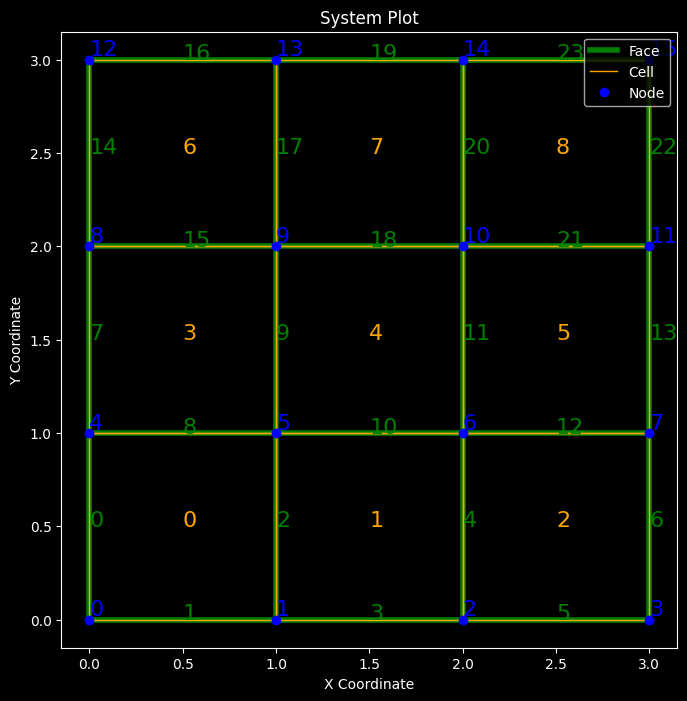

In [29]:
# Example Usage
system_size = (3, 3)  # Width and height of the system
num_cells = (3, 3)  # Number of cells in x and y directions
mesh = Mesh(*create_2d_rectangular_mesh(system_size, num_cells))
mesh.compute_cell_connectivity()

# print(mesh)
# mesh.print_detailed_info()
# for cell in mesh.cells:
#     print(cell)

mesh.plot()

#### Assigning flow variables to cells based on a field

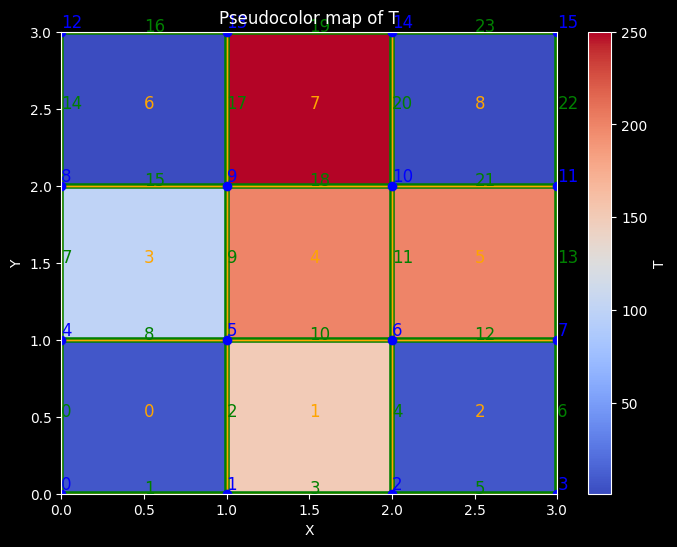

In [30]:
# temp_field = np.ones(num_cells) * 290 + np.random.randn(*num_cells) * 10
# pressure_field = np.ones(num_cells) * 101
# assign_field_to_cells(mesh, pressure_field.flatten(), "P")
# velocity_field = np.ones((*num_cells,2)) * 0
# velocity_field = velocity_field.reshape(-1, 2)
# assign_field_to_cells(mesh, velocity_field, "U")

temp_field = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
]) * 10
temp_field = np.array([
    [1,1,1],
    [4,4,4],
    [7,7,7]
]) * 10

temp_field = np.array([
    [1,250,1],
    [100,200,200],
    [7,150,7]
])
temp_field = np.flip(temp_field.T, axis=1) # necessary to assign first row top, last row bottom part of mesh
assign_field_to_cells(mesh, temp_field.flatten(), "T")
# mesh.print_detailed_info("C")
plot_scalar_field(mesh, "T", num_cells, system_size, plot_mesh=True)


#### Calculating cell volumes

In [31]:
cell_volumes = []
for cell in mesh.cells:
    cell_nodes = [mesh.get_node(node_id) for node_id in cell.nodes]
    cell_volume = compute_cell_volume(mesh, cell)
    cell_volumes.append(cell_volume)
print(cell_volumes)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


#### Calculating gradient of a field in the system

In [52]:
cell = mesh.get_cell(4)
grad = green_gauss_gradient(mesh, cell, field_key = "T", is_cell_based = True)
print(grad)

grad = least_squares_gradient(mesh, cell, field_key = "T") # this works correctly
print(grad)

[-115.13878189  -80.27756377]
[50. 50.]


### Calculating diffusion of a cell

In [54]:
cell = mesh.get_cell(4)
diffusion_fluxes = compute_diffusion(mesh, cell, field_key = "T")
print(diffusion_fluxes) # face_id -> face_flux

cell = mesh.get_cell(5)
diffusion_fluxes = compute_diffusion(mesh, cell, field_key = "T")
print(diffusion_fluxes) # face_id -> face_flux

# NOTE: For each face rhs and lhs have same magnitude and different sign

{9: -100.0, 10: -200.0, 11: 100.0, 18: 0.0}
{11: -100.0, 12: -498.0, 13: 0.0, 21: -498.0}
